# Yao - Data Challenge - Cummins

# 4) Provide a copy of the code and outputs used  for the index evaluation, model development, evaluation and predictions.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
#use more RAM
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

#note: no timeseries packages were used, all were recalculated on an intuitive level using pure pandas and datetime when modeling
    
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import re
import gc
from sklearn.model_selection import train_test_split

In [2]:
cust= pd.read_excel(r'Data Challenge.xlsx',sheet_name=2)
cust

,Month,Customer Volumes
0,201101,908
1,201102,986
2,201103,1276
3,201104,2066
4,201105,1856
5,201106,1830
6,201107,1489
7,201108,1604
8,201109,1632
9,201110,2367


In [3]:
index= pd.read_excel(r'Data Challenge.xlsx',sheet_name=3)
index

,Month,Type,IDX1,IDX2,IDX3
0,201101,Closed Month,92.690595,108.008014,101.28420
1,201102,Closed Month,97.914192,102.123691,101.33520
2,201103,Closed Month,108.645217,101.238374,101.23920
3,201104,Closed Month,116.243167,109.568848,100.99170
4,201105,Closed Month,108.068513,110.511852,100.59400
5,201106,Closed Month,105.845455,113.853175,100.34200
6,201107,Closed Month,107.916611,116.825030,100.07270
7,201108,Closed Month,100.486425,111.830988,99.89741
8,201109,Closed Month,100.819351,109.978370,99.78014
9,201110,Closed Month,99.847754,108.783022,99.69215


In [4]:
full = pd.merge(cust,index,on='Month', how='outer').drop(columns = 'Type')
full

,Month,Customer Volumes,IDX1,IDX2,IDX3
0,201101,908.0,92.690595,108.008014,101.28420
1,201102,986.0,97.914192,102.123691,101.33520
2,201103,1276.0,108.645217,101.238374,101.23920
3,201104,2066.0,116.243167,109.568848,100.99170
4,201105,1856.0,108.068513,110.511852,100.59400
5,201106,1830.0,105.845455,113.853175,100.34200
6,201107,1489.0,107.916611,116.825030,100.07270
7,201108,1604.0,100.486425,111.830988,99.89741
8,201109,1632.0,100.819351,109.978370,99.78014
9,201110,2367.0,99.847754,108.783022,99.69215


In [5]:
full['Date'] = pd.to_datetime(full['Month'], format="%Y%m")

In [6]:
full['Customer Volumes'][99:111] = full['Customer Volumes'][87:99]
full['Customer Volumes'][111:117] = full['Customer Volumes'][87:93]

In [7]:
full['Month'] = full['Date'].dt.month
full['Year'] = full['Date'].dt.year

# 1) Analyze the influence of the indexes as leading indicators on the customer volumes .
    - Business has provided historical values plus an 18 month forecast
    
The 3 indexes are plotted as follows where one is flat and the others have some seasonality.

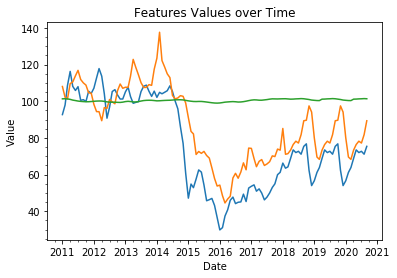

In [8]:
features = ['IDX1','IDX2','IDX3']
for f in features:
    plt.plot('Date',f,data=full,label = f)
    plt.minorticks_on()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Features Values over Time')
    plt.show;

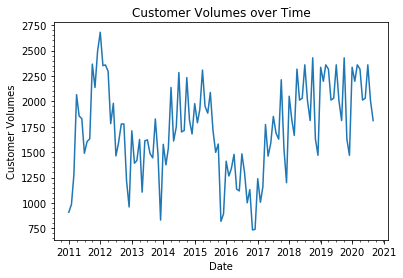

In [9]:
plt.plot('Date','Customer Volumes',data=full,label = f)
plt.minorticks_on()
plt.xlabel('Date')
plt.ylabel('Customer Volumes')
plt.title('Customer Volumes over Time')
plt.show;

In [10]:
full.info()
full = full.set_index('Date')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 116
Data columns (total 7 columns):
Month               117 non-null int64
Customer Volumes    117 non-null float64
IDX1                117 non-null float64
IDX2                117 non-null float64
IDX3                117 non-null float64
Date                117 non-null datetime64[ns]
Year                117 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 7.3 KB


Distribution of data

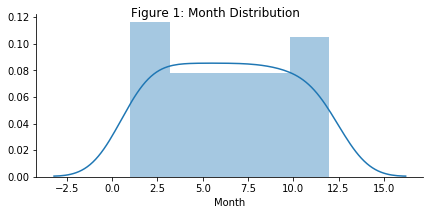

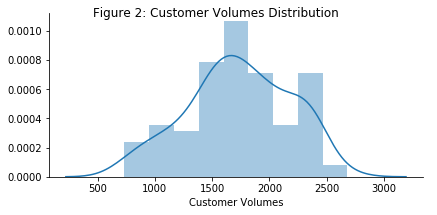

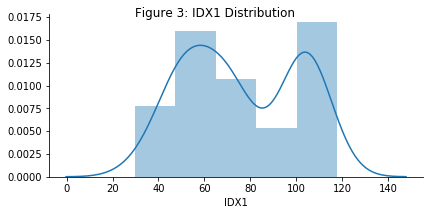

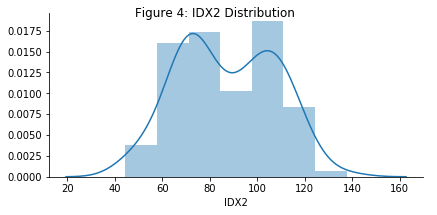

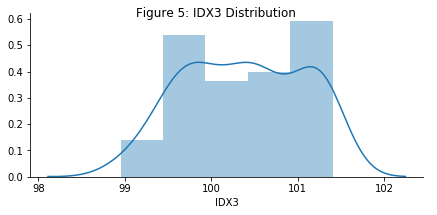

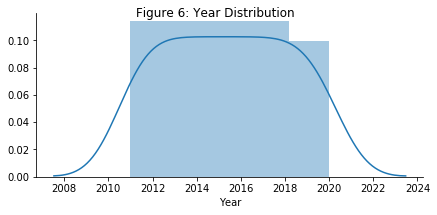

In [11]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(full.select_dtypes(exclude='datetime64').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(full,aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution"]))))
    plt.show()

In [12]:
df = full.copy()
y = df.pop('Customer Volumes')

shift = [-3,-2,-1,1,2,3]
        
for col in df.columns:
    for i in shift:
        df["%s_%s"%(col,i)] = df[col].shift(i)

# 2) Develop a 18 month forecast of the customer volumes using either Python or R, and the selected indexes.

Given that shift -2 to 2 can be filled in via projected data that is just recent data repeated, the test set and future projection is much fuller.

In [13]:
df=df.dropna()
df

,Month,IDX1,IDX2,IDX3,Year,Month_-3,Month_-2,Month_-1,Month_1,Month_2,...,IDX3_-1,IDX3_1,IDX3_2,IDX3_3,Year_-3,Year_-2,Year_-1,Year_1,Year_2,Year_3
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,4,116.243167,109.568848,100.99170,2011,7.0,6.0,5.0,3.0,2.0,...,100.59400,101.23920,101.33520,101.28420,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-05-01,5,108.068513,110.511852,100.59400,2011,8.0,7.0,6.0,4.0,3.0,...,100.34200,100.99170,101.23920,101.33520,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-06-01,6,105.845455,113.853175,100.34200,2011,9.0,8.0,7.0,5.0,4.0,...,100.07270,100.59400,100.99170,101.23920,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-07-01,7,107.916611,116.825030,100.07270,2011,10.0,9.0,8.0,6.0,5.0,...,99.89741,100.34200,100.59400,100.99170,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-08-01,8,100.486425,111.830988,99.89741,2011,11.0,10.0,9.0,7.0,6.0,...,99.78014,100.07270,100.34200,100.59400,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-09-01,9,100.819351,109.978370,99.78014,2011,12.0,11.0,10.0,8.0,7.0,...,99.69215,99.89741,100.07270,100.34200,2011.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-10-01,10,99.847754,108.783022,99.69215,2011,1.0,12.0,11.0,9.0,8.0,...,99.70814,99.78014,99.89741,100.07270,2012.0,2011.0,2011.0,2011.0,2011.0,2011.0
2011-11-01,11,105.405014,104.557598,99.70814,2011,2.0,1.0,12.0,10.0,9.0,...,99.82206,99.69215,99.78014,99.89741,2012.0,2012.0,2011.0,2011.0,2011.0,2011.0
2011-12-01,12,104.230476,104.402928,99.82206,2011,3.0,2.0,1.0,11.0,10.0,...,99.95207,99.70814,99.69215,99.78014,2012.0,2012.0,2012.0,2011.0,2011.0,2011.0


In [14]:
train_idx = pd.date_range(start='4/1/2011', end='8/1/2017', freq='MS')
test_idx = pd.date_range(start='9/1/2017', end='3/1/2019', freq='MS')
predict_idx = pd.date_range(start='4/1/2019', end='6/1/2020', freq='MS')
total_idx = pd.date_range(start='4/1/2011', end='6/1/2020', freq='MS')

In [15]:
model2 = RandomForestRegressor(n_estimators=100, random_state=2)

model2.fit(df.loc[train_idx],y.loc[train_idx])
error = abs(model2.predict(df.loc[test_idx]) - y.loc[test_idx])
print('Mean Absolute Error:', round(np.mean(error), 2), 'volume')
print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 311.36 volume
Accuracy: 84.54 %.


In [16]:
model3 = ExtraTreesRegressor(n_estimators=100, random_state=2)

model3.fit(df.loc[train_idx],y.loc[train_idx])
error = abs(model3.predict(df.loc[test_idx]) - y.loc[test_idx])
print('Mean Absolute Error:', round(np.mean(error), 2), 'volume')
print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 410.79 volume
Accuracy: 80.43 %.


In [17]:
model4 = XGBRegressor(n_estimators=100, random_state=2)

model4.fit(df.loc[train_idx],y.loc[train_idx])
error = abs(model4.predict(df.loc[test_idx]) - y.loc[test_idx])
print('Mean Absolute Error:', round(np.mean(error), 2), 'volume')
print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

[09:51:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 331.89 volume
Accuracy: 83.99 %.


In [18]:
def modelmetrics(model, X, Y, trainidx = None, testidx = None, futureidx = None):
    metrics = {}
    f = '_'
    
    #model data
    metrics['Model'] = model
    metrics['Model Detail'] = re.sub('[^A-Za-z0-9(,.=]+', '', str(metrics['Model']))
    metrics['Model Name'] = re.sub('[^A-Za-z0-9()]+', '', str(model)).split('(', 1)[0]
    
    #in the event of no testing training idx, make it; otherwise, set it
    if trainidx is None:
        xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=2)
    else:
        xtrain = X.loc[trainidx]
        ytrain = Y.loc[trainidx]
        xtest = X.loc[testidx]
        ytest = Y.loc[testidx]
    
    #in the event that there is no model for the monthly scale and that predictions are aggregated and inherited, then just set it; otherwise, run fit and predict model
    try:    
        model.fit(xtrain,ytrain)
        ypred = model.predict(xtest)
    except:
        ypred = X.loc[testidx]
        ytest = Y.loc[testidx]
    
    #find relative accuracy. MSE is not used because we want to be accurate for ambient data without the weight bias for high data 'spikes' for MSE
    metrics['Accuracy'] = round(100 - np.mean(100 * (abs(ypred - ytest) / ytest)),2)
    
    #in the event that regression has no feature importance, skip; otherwise, get top 5 features and place in dictionary and title string
    try:
        feature_importances = pd.Series(model.feature_importances_, index=df.columns)
        for i in range(5):
            metrics['TopFeature'+str(i+1)] = feature_importances.sort_values(ascending=False).index[i]
            f += ' '+feature_importances.sort_values(ascending=False).index[i]
    except:
        pass
    
    #in the event that there is no model, set future ids and calculate future accuracy; otherwise, predict future accuracy of model with future projected as guiderails. set title
    if futureidx is not None:
        xfuture = X.loc[futureidx]
        yfuture = Y.loc[futureidx]
        try:
            ypredfuture = model.predict(xfuture)
        except:
            ypredfuture = xfuture
        metrics['Future Accuracy'] = round(100 - np.mean(100 * (abs(ypredfuture - yfuture) / yfuture)),2)
        metrics['Title']=' Search Full Test Acc - '+str(metrics['Accuracy'])+' Future Acc - '+str(metrics['Future Accuracy'])+'_'+metrics['Model Name']+f
   
    return metrics

# 3) Conduct an evaluation of the model(s) developed.

Using random forest, xgboost, and extra tree regressors while optimizing for hyperparameters, the test set has a max accuracy of 85% and a projected accuracy of 85%.

In [19]:
optimize = True

models = [RandomForestRegressor(n_estimators=100, random_state=2), 
            XGBRegressor(n_estimators=100, random_state=2), 
            ExtraTreesRegressor(n_estimators=100, random_state=2)]

#add optimization hyperparameters on top of those regressors
if optimize == True:
    regressors = [RandomForestRegressor(random_state=2,n_jobs=-1), XGBRegressor(random_state=2,n_jobs=-1), ExtraTreesRegressor(random_state=2,n_jobs=-1)]
    hyperparameters = [{'min_samples_split': [2,3,4],
                       'max_features': ['auto'],
                       'criterion': ['mse'],
                       'n_estimators': [100, 500, 1000]
                      },
                      {'objective':['reg:linear'],
                      'min_child_weight': [1, 2, 3],
                      'n_estimators': [100, 500, 1000]
                      },
                      {'min_samples_split': [2,3,4],
                       'max_features': ['auto'],
                       'criterion': ['mse'],
                       'n_estimators': [100, 500, 1000]
                      }]

    #gridsearch for best hyperparameters when fitting training set with MSE. append the optimized models to the list of models
    for r,h in zip(regressors,hyperparameters):
        search = GridSearchCV(r, h, cv=5, scoring = 'neg_mean_squared_error')
        search.fit(df.loc[train_idx],y.loc[train_idx])
        models.append(search.best_estimator_)

#set the metrics as 0 so that the loop does not inherit any previous data from previous loops of data
metrics1 = {}
metrics1['Accuracy'] = -1000000
metrics1['Future Accuracy'] = -1000000
metrics = {}

#loop through the 6 models and use relative accuracy as a metric after optimizing w/ MSE using gridsearch. set the winning metrics if 2*accuracy + 1*futureaccuracy is larger
for m in models:
    metrics = modelmetrics(m, df, y, train_idx, test_idx, predict_idx)
    if (metrics1['Accuracy']*2+metrics1['Future Accuracy']) < (metrics['Accuracy']*2+metrics['Future Accuracy']):
        metrics1 = metrics
print(metrics1)

C:\Users\Yao\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[09:51:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNI

C:\Users\Yao\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[09:52:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Yao\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[09:52:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=2, verbose=0,
                      warm_start=False), 'Model Detail': 'RandomForestRegressor(bootstrap=True,criterion=mse,maxdepth=None,maxfeatures=auto,maxleafnodes=None,minimpuritydecrease=0.0,minimpuritysplit=None,minsamplesleaf=1,minsamplessplit=3,minw

In [20]:
def modelplot(metrics, xtotal, ytotal, df, start, end, winner = False):
    df = df.reset_index()
    plt.figure(figsize = (20,15))

    # Plot the actual values
    plt.plot(df['index'], ytotal, 'b-', label = 'actual')
    
#     Plot the predicted values or plot inherited aggregate values on the monthly scale
#     try:
    plt.plot(df.reset_index()['index'], pd.Series(metrics['Model'].predict(xtotal), index=df.index), 'ro', label = 'prediction')
#     except:
#         plt.plot(df['index'][total_idx], xtotal, 'ro', label = 'prediction')
    
    #shade the region of test range
    plt.axvspan(start, end, alpha=0.3, color='m')
    plt.legend()
    plt.minorticks_on()

    # Graph labels
    plt.xlabel('Date')
    plt.ylabel('Search Volume')
    plt.title(metrics['Title'])
    
    #save to disk only if model is best on daily or monthly scale
    if winner == True:
        plt.savefig(metrics['Title']+'.png')
    plt.show();

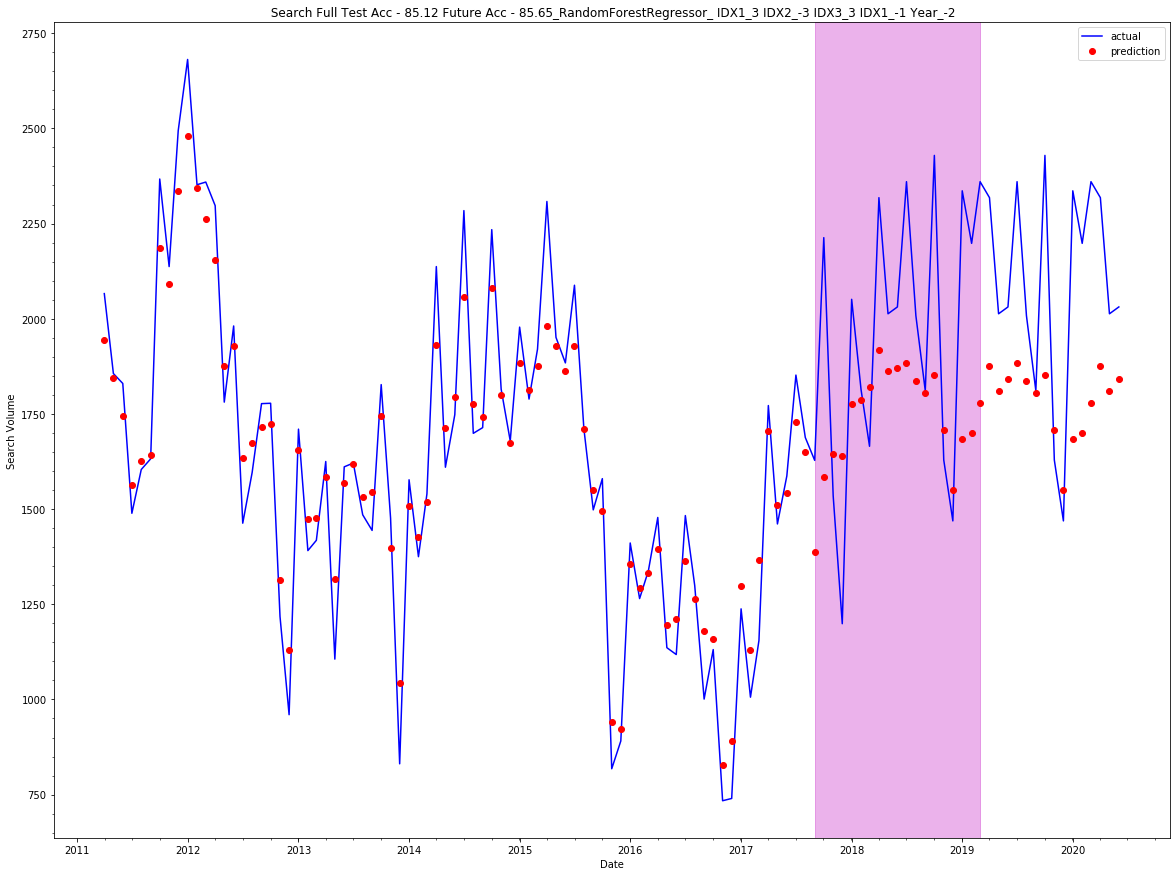

In [21]:
modelplot(metrics1, df.loc[total_idx], y.loc[total_idx], full.loc[total_idx], test_idx[0], test_idx[-1], True)

# 5) Be prepared for a follow up discussion on the modeling process.  In addition, prepare for a discussion on what would you do next?  

The test data set and future projection has a dampening where it does not fully adhere to the volatility of the real target data but rather estimates around the median.

Next steps include merge more time series features that would contribute to the better prediction of time series target data. The prediction did well for only 3 features.